<a href="https://colab.research.google.com/github/serereuk/RA_code/blob/master/10%EC%A3%BC%EC%B0%A8/testing1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 2차원 인풋이 아닌 다른 차원 인풋이 들어가면 어떻게 될까??

In [1]:
from google.colab import files
data = files.upload()

Saving khc1.txt to khc1.txt
Saving yjh1.txt to yjh1.txt
Saving yjh2.txt to yjh2.txt
Saving khc2.txt to khc2.txt


In [0]:
import pandas as pd
import numpy as np
data = pd.read_csv("khc1.txt")

In [0]:
def timecut(data):
    temps = pd.DataFrame()
    x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
    y = [0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
    for i in range(0, 16):
        temp = pd.DataFrame({"X": data.ALX.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)],
                            "Y": data.ALY.loc[(data.ATT >= 2 + 5 * i) & (data.ATT < 7  + 5 * i)]})
        temp = pd.concat([temp.reset_index(), pd.DataFrame( {"x":[x[i]]*temp.shape[0]} ), pd.DataFrame({"y":[y[i]]*temp.shape[0]}) ], axis = 1)
        temps = pd.concat([temps, temp])
    return temps
  
def constrain(data):
  data['X2'] = data.X**2
  data['Y2'] = data.Y**2
  data = data.loc[data.X2 <= 1]
  data = data.loc[data.Y2 <= 1]
  return data

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
from tqdm import tnrange

In [0]:
batch_size = 128
epoch = 4000
H = 100
import os
os.chdir('/content')

In [0]:
os.mkdir('node_'+str(H)+'_size_'+str(batch_size)+'_epoch_'+str(epoch)+'_yjh22_constrain_xy')
os.chdir('node_'+str(H)+'_size_'+str(batch_size)+'_epoch_'+str(epoch)+'_yjh22_constrain_xy')
#names = 'node'+str(H)+'size'+str(size)+'epoch'+str(epoch)+'model1'

In [0]:
from torch.utils.data import Dataset, DataLoader

class dss(Dataset):
    def __init__(self, a):
        np.random.seed(1234)
        a = timecut(a).iloc[:,1:5]
        a = constrain(a)
        a['XY'] = a.X * a.Y
        self.len = a.shape[0]
        self.x_data = torch.from_numpy(a[['X', 'Y', 'XY']].values).float()
        self.y_data = torch.from_numpy(a.iloc[:,2:4].values).float()
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

size = len(data)
indices = list(range(size))
split = int(np.floor(0.1 * size))
np.random.seed(123)
np.random.shuffle(indices)


train_indices, test_indices = indices[split:], indices[:split]
train_data=data.iloc[train_indices, :]
test_data = data.iloc[test_indices, :]
dstrain = dss(train_data)
dstest = dss(test_data)
trainloader = DataLoader(dataset = dstrain, batch_size = batch_size, shuffle = True)
testloader = DataLoader(dataset = dstest, batch_size = 1000, shuffle = True)
device = torch.device("cuda:0")

In [0]:
class optim1(nn.Module):
    
    def __init__(self, inputs, H,outputs):
        super(optim1, self).__init__()
        self.linear1 = torch.nn.Linear(inputs, H).cuda()
        self.linear2 = torch.nn.Linear(H, H).cuda()
        self.linear3 = torch.nn.Linear(H, H).cuda()
        self.linear4 = torch.nn.Linear(H, H).cuda()
        self.linear5 = torch.nn.Linear(H, H).cuda()
        self.linear6 = torch.nn.Linear(H, outputs).cuda()
        
    def forward(self, x):
        h_relu = torch.relu(self.linear1(x))
        h_relu = torch.relu(self.linear2(h_relu))
        h_relu = torch.relu(self.linear3(h_relu))
        h_relu = torch.relu(self.linear4(h_relu))
        h_relu = torch.relu(self.linear5(h_relu))
        y_pred = torch.sigmoid(self.linear6(h_relu))
        return y_pred
        

In [32]:
inputs, outputs = 3, 2
for_graph = []; test_loss = []

model = optim1(inputs, H, outputs)
criteria = torch.nn.L1Loss(size_average= True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

for t in tnrange(epoch):
    for i, datas in enumerate(trainloader):
        In, label = datas
        In, label = V(In), V(label)
        In, label = In.cuda(), label.cuda()
        y_pred = model(In)
        loss = criteria(y_pred, label)
        if t % 100 == 99:
            for_graph.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if t % 100 == 99:
            with torch.no_grad():
                for datass in testloader:
                    In, label = datass
                    In, label = In.cuda(), label.cuda()
                    outputs = model(In)
                    test_loss.append(np.mean((label.cpu().numpy() - outputs.cpu().numpy())**2))

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

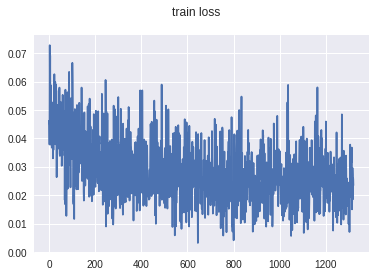

In [34]:
plt.plot(np.arange(len(for_graph)), for_graph)
plt.suptitle('train loss')
plt.savefig('train ' + 'batch_size '+ str(batch_size) + ' epoch '+str(epoch)+' node '+str(H) + ' model optim1.jpg')

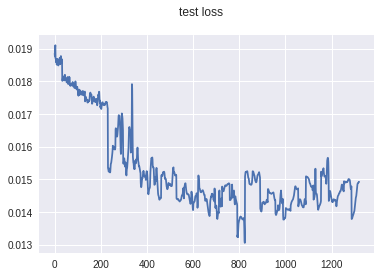

In [35]:
plt.plot(np.arange(len(test_loss)), test_loss)
plt.suptitle('test loss')
plt.savefig('test ' + 'batch_size '+ str(batch_size) + ' epoch '+str(epoch)+' node '+str(H) + ' model optim1.jpg')

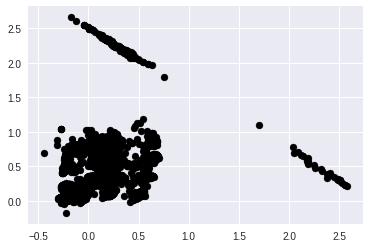

In [36]:
plt.scatter(data.loc[data.ATT < 85].ALX, data.loc[data.ATT < 85].ALY, c = "black")
plt.savefig('khc1_original.jpg')

In [39]:
datas = data.loc[data.ATT < 85]
datas['XY'] = datas.ALX * datas.ALY
out = pd.DataFrame(model(torch.from_numpy(datas[['ALX', 'ALY', 'XY']].values).float().cuda()).detach().cpu().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


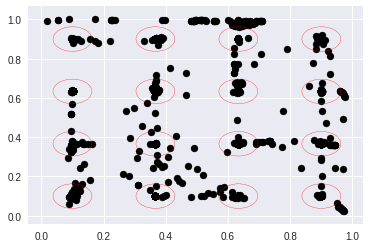

In [40]:
ax = plt.gca()
ax.scatter(out.iloc[:,0], out.iloc[:,1], c= "black")
x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
y=[0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
for i in range(len(x)):
    temp = plt.Circle((x[i], y[i]), 1/16, color = "r", fill = False)
    ax.add_artist(temp)
plt.savefig('khc1_correct.jpg')

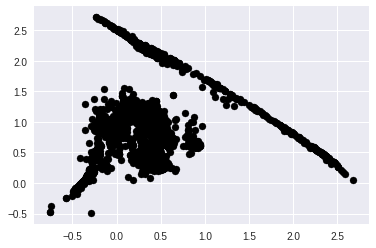

In [41]:
plt.scatter(data.loc[data.ATT >data.ATT.tolist()[-1] - 84].ALX, data.loc[data.ATT >data.ATT.tolist()[-1] - 84].ALY, c = "black")
plt.savefig('khc1_original2.jpg')

In [42]:
datas2 = data.loc[data.ATT > data.ATT.tolist()[-1] - 84]
datas2['XY'] = datas2.ALX * datas2.ALY

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [43]:
datas2['X2'] = datas2.ALX**2
datas2['Y2'] = datas2.ALY**2
datas2 = datas2.loc[(datas2.X2 <= 1) |(datas2.Y2 <=1)]
datas3 = datas2.loc[(datas2.Y2 > 1) | (datas2.X2 > 1)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
out = pd.DataFrame(model(torch.from_numpy(datas2[['ALX', 'ALY', 'XY']].values).float().cuda()).detach().cpu().numpy())
out2 = pd.DataFrame(model(torch.from_numpy(datas3[['ALX', 'ALY', 'XY']].values).float().cuda()).detach().cpu().numpy())
datas3.ATT = datas3.ATT - 373.3342

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


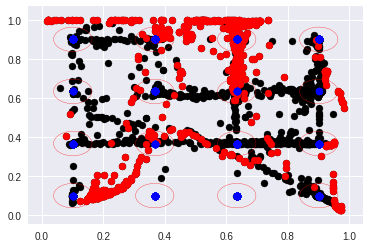

In [45]:
ax = plt.gca()
ax.scatter(out.iloc[:,0], out.iloc[:,1], c= "black")
ax.scatter(out2.iloc[:,0], out2.iloc[:,1], c= "red")
ax.scatter(timecut(datas3).x, timecut(datas3).y, c= "blue")
x=[0.1,11/30,0.9,0.1,0.9,0.9,0.1,19/30,19/30,11/30,19/30,11/30,11/30,0.9,0.1,19/30]
y=[0.1,19/30,0.9,11/30,19/30,0.1,0.9,0.9,0.1,0.9,19/30,0.1,11/30,11/30,19/30,11/30]
for i in range(len(x)):
    temp = plt.Circle((x[i], y[i]), 1/16, color = "r", fill = False)
    ax.add_artist(temp)
plt.savefig('khc1_correct2.jpg')